In [39]:
import sys
sys.path.append('..')
import h5py
import functions.data_class as data_class
import functions.plot as plot
import matplotlib.pyplot as plt
import importlib
import numpy as np
importlib.reload(plot)
importlib.reload(data_class)
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Polygon
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

dpi = 600

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['savefig.dpi'] = dpi
plt.style.use(['science','ieee', 'scatter'])
plt.rcParams['figure.figsize'] = 5,5



In [114]:
%config InlineBackend.figure_format = 'svg'

In [115]:
%%html
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>

In [175]:
# statistic tests output
proj_12 = '../statistic_test_result/fib_10000/proj_test_12.h5'
proj_13 = '../statistic_test_result/fib_10000/proj_test_13.h5'
mcf_12 = '../statistic_test_result/fib_10000/mcf_slope_test_12_10000.h5'
mcf_13 = '../statistic_test_result/fib_10000/mcf_slope_test_13_10000.h5'
dgf_12 = '../statistic_test_result/fib_10000/dgf_test_12_10000.h5'
dgf_13 = '../statistic_test_result/fib_10000/dgf_test_13_10000.h5'

In [176]:
p12 = data_class.read_data(proj_12)
p13 = data_class.read_data(proj_13)
m12 = data_class.read_data(mcf_12)
m13 = data_class.read_data(mcf_13)
d12 = data_class.read_data(dgf_12)
d13 = data_class.read_data(dgf_13)

In [177]:
import matplotlib
fig, ax1 = plt.subplots()
type(ax1)

matplotlib.axes._subplots.AxesSubplot

In [184]:
import functions.plot as plot
importlib.reload(plot)

<module 'functions.plot' from '..\\functions\\plot.py'>

In [185]:
x1 = np.arange(14)
x2 = np.arange(13)

mean_number_of_para_proj_13 = [np.sum(p13['probability'][i] * p13['n_para_proj'][i]) for i in range(14)]
mean_number_of_para_proj_12 = [np.sum(p12['probability'][i] * p12['n_para_proj'][i]) for i in range(13)]

likeli_para_proj_13 = p13['probability'][:,5]/np.max(p13['probability'][:,5])
likeli_para_proj_12 = p12['probability'][:,6]/np.max(p12['probability'][:,6])

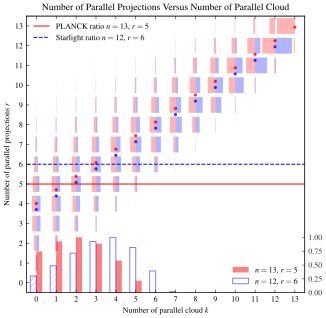

In [212]:
importlib.reload(plot)
plot.plot_statistic_test_discrete(
    x1=x1, y1=mean_number_of_para_proj_13,li1=likeli_para_proj_13, 
    bar_coord1=x1, prob1=p13['probability'], obs1= 5,
    x2=x2, y2=mean_number_of_para_proj_12,li2=likeli_para_proj_12, 
    bar_coord2=x2, prob2=p12['probability'], obs2= 6,
    xlim=(-0.5, 13.5), ylim=(-0.5, 13.5), bottom_scale=0.2,
    xlabel='Number of parallel cloud $k$', ylabel="Number of parallel projections $r$",
    title="Number of Parallel Projections Versus Number of Parallel Cloud",
    likeli_label1="$n=13$, $r=5$", likeli_label2="$n=12$, $r=6$",
    obs_label1="PLANCK ratio $n=13$, $r=5$", 
    obs_label2="Starlight ratio $n=12$, $r=6$")
    

array([7.45975550e-01, 9.26983040e-01, 1.00000000e+00, 8.85582502e-01,
       5.79897586e-01, 2.17848860e-01, 8.49479503e-03, 1.99128192e-04,
       3.58404240e-06, 5.45989851e-08, 7.40500589e-10, 9.21442961e-12,
       1.07274858e-13, 1.18429777e-15])

In [121]:
def plot_fig_2(f1, y1, li1, bar1, prob1, f2, y2, li2, bar2, prob2, obs1, obs2):
    """
    plot test 2 result.
    """
    
    fig, ax1 = plt.subplots()
    
    # Line plot with error bar
    # ax1.errorbar(f1, y1, yerr = sd1, capsize=10, color = 'red')
    # ax1.errorbar(f2, y2, yerr = sd2, capsize=10, color = 'blue')
    ax1.plot(f1, y1, color = 'red' , marker = 'o', fillstyle = 'full', alpha = 0.7, markersize = 5)
    ax1.plot(f2, y2, color = 'blue', marker = 'o', fillstyle = 'none', alpha = 0.7, markersize = 5)


    # Horizontal line for observation.
    ax1.hlines(obs1, -1, 14,  color = 'red', ls = 'solid', label = r"PLANCK ratio: $n =13$, $r = 5$")
    ax1.hlines(obs2, -1, 14,  color = 'blue', ls = 'dashed', label = r"Optical ratio: $n =12$, $r = 6$")
    
    # Vertical plot 
    prob1 /= np.max([np.max(prob1), np.max(prob2)])
    prob2 /= np.max([np.max(prob1), np.max(prob2)])
    
    for i, prob in enumerate(prob1):
        plot_vd_cont(ax1, i, bar1, prob, 0.5, dir = 'l', color = 'red', w = 0.01, alpha = 0.5)

    for i, prob in enumerate(prob2):
        plot_vd_cont(ax1, i, bar2, prob, 0.5, dir = 'r', color = 'blue', w = 0.01, alpha = 0.3)
    
    
    
    # legend.
    ax1.legend(loc = 'upper right')
    
    # other setting.
    ax1.set_title("Relative MCF Difference for Different Number of Parallel Clouds")
    ax1.set_ylabel("Relative MCF difference $(R)$")
    ax1.set_xlabel("Number of parallel clouds ($k$)")
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(-0.7, 13.7)
    ax1.set_xticks(np.arange(0, 14), ["%d"%i for i in np.arange(0, 14)])
    # ax1.set_yticks(np.linspace(-0.6, 0.6, 13), ["%.1f"%i for i in np.linspace(-0.6, 0.6, 13)])
    
    
    # small plot for likelihood
    ax2 = ax1.twinx()

    # bar plot for likelihood function    
    w = 0.6

    ax2.bar(f1+w/4, 0.4*li1 , label = "$n = 13, r = 5$", width = w/2, color = 'red', alpha = 0.5)
    ax2.bar(f2-w/4, 0.4*li2 , label = "$n = 12, r = 6$", width = w/2, edgecolor = 'blue', alpha = 0.5, fill = False, hatch = '////', )
    
    ax2.set_ylim(0, 1)
    ax2.set_yticks(np.linspace(0, 0.4, 6), labels = ['%.2f' % i for i in np.linspace(0, 1, 6)])
    ax2.legend(loc = 'lower right', ncol = 1)
    ax2.set_ylabel("Relative Likelihood Function", labelpad = 10, loc = 'bottom')
    
    
    # plt.savefig("../images/mcf_slope.png", dpi = dpi)
    plt.show()

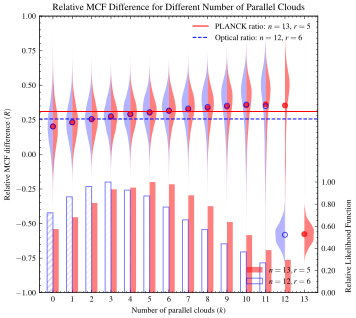

In [122]:
x1 = np.arange(14)
x2 = np.arange(13)

y1 = [np.nanmean(m13['result'][i]) for i in range(14)]
y2 = [np.nanmean(m12['result'][i]) for i in range(13)]

kde13 = [st.gaussian_kde(m13['result'][i][~np.isnan(m13['result'][i])]) for i in range(14)]
kde12 = [st.gaussian_kde(m12['result'][i][~np.isnan(m12['result'][i])]) for i in range(13)]

planck_mcf = 0.30980160604629208843
optical_mcf = 0.25598335067637884022

bar = np.linspace(-0.8, 0.92, 1000)

likeli13 = np.array([k.pdf(planck_mcf)[0] for k in kde13])
likeli12 = np.array([k.pdf(optical_mcf)[0] for k in kde12])

likeli13 /= np.max(likeli13)
likeli12 /= np.max(likeli12)


prob13 = [k.pdf(bar) for k in kde13]
prob12 = [k.pdf(bar) for k in kde12]

plot_fig_2(x1, y1, likeli13, bar, prob13, x2, y2, likeli12, bar, prob12, planck_mcf, optical_mcf)

In [123]:
def plot_fig_2(f1, y1, li1, bar1, prob1, f2, y2, li2, bar2, prob2, obs1, obs2):
    """
    plot test 2 result.
    """
    
    fig, ax1 = plt.subplots()
    
    # Line plot with error bar
    # ax1.errorbar(f1, y1, yerr = sd1, capsize=10, color = 'red')
    # ax1.errorbar(f2, y2, yerr = sd2, capsize=10, color = 'blue')
    ax1.plot(f1, y1, color = 'red' , marker = 'o', fillstyle = 'full', alpha = 0.7, markersize = 5)
    ax1.plot(f2, y2, color = 'blue', marker = 'o', fillstyle = 'none', alpha = 0.7, markersize = 5)


    # Horizontal line for observation.
    ax1.hlines(obs1, -1, 14,  color = 'red', ls = 'solid', label = r"PLANCK ratio: $n =13$, $r = 5$")
    ax1.hlines(obs2, -1, 14,  color = 'blue', ls = 'dashed', label = r"Optical ratio: $n =12$, $r = 6$")
    
    # Vertical plot 
    prob1 /= np.max([np.max(prob1), np.max(prob2)])
    prob2 /= np.max([np.max(prob1), np.max(prob2)])
    
    for i, prob in enumerate(prob1):
        plot_vd_cont(ax1, i, bar1, prob, 0.5, dir = 'l', color = 'red', w = 0.01, alpha = 0.5)

    for i, prob in enumerate(prob2):
        plot_vd_cont(ax1, i, bar2, prob, 0.5, dir = 'r', color = 'blue', w = 0.01, alpha = 0.3)
    
    
    
    # legend.
    ax1.legend(loc = 'upper right')
    
    # other setting.
    ax1.set_title("Relative MCF Difference for Different Number of Parallel Clouds")
    ax1.set_ylabel("Relative MCF difference $(R)$")
    ax1.set_xlabel("Number of parallel clouds ($k$)")
    ax1.set_ylim(-3, 1)
    ax1.set_xlim(-0.7, 13.7)
    # ax1.set_xticks(np.arange(0, 14), ["%d"%i for i in np.arange(0, 14)])
    # ax1.set_yticks(np.linspace(-0.6, 0.6, 13), ["%.1f"%i for i in np.linspace(-0.6, 0.6, 13)])
    
    
    # small plot for likelihood
    ax2 = ax1.twinx()

    # bar plot for likelihood function    
    w = 0.6

    ax2.bar(f1+w/4, 0.4*li1 , label = "$n = 13, r = 5$", width = w/2, color = 'red', alpha = 0.5)
    ax2.bar(f2-w/4, 0.4*li2 , label = "$n = 12, r = 6$", width = w/2, edgecolor = 'blue', alpha = 0.5, fill = False, hatch = '////', )
    
    ax2.set_ylim(0, 1)
    ax2.set_yticks(np.linspace(0, 0.4, 6), labels = ['%.2f' % i for i in np.linspace(0, 1, 6)])
    ax2.legend(loc = 'lower right', ncol = 1)
    ax2.set_ylabel("Relative Likelihood Function", labelpad = 10, loc = 'bottom')
    
    
    # plt.savefig("../images/test_dgf.png", dpi = dpi)
    plt.show()

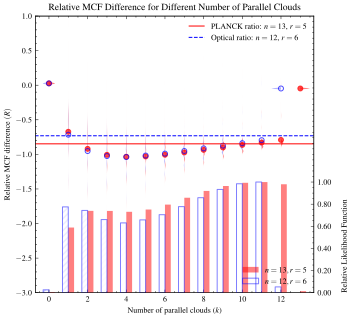

In [124]:
def normal(x, mu, sig):
    
    N = 1/np.sqrt(2*np.pi)
    N /= sig
    
    X = (x - mu)/sig
    X **= 2
    X /= -2
    
    return N * np.exp(X)

x1 = np.arange(14)
x2 = np.arange(13)

y1 = [np.nanmean(d13['result'][i]) for i in range(14)]
y2 = [np.nanmean(d12['result'][i]) for i in range(13)]

kde13 = [st.gaussian_kde(d13['result'][i][~np.isnan(d13['result'][i])]) for i in range(14)]
kde12 = [st.gaussian_kde(d12['result'][i][~np.isnan(d12['result'][i])]) for i in range(13)]

planck_mcf = -0.84750463013795462874
optical_mcf = -0.73118733558613902002



bar = np.linspace(-3, 1, 1000)

planck_dgf = normal(bar, planck_mcf, 0.27234865847532124805)
optical_dgf = normal(bar, optical_mcf, 0.27578346005628745496)


likeli13d = np.array([np.sum(k.pdf(bar)*planck_dgf) for k in kde13])
likeli12d = np.array([np.sum(k.pdf(bar)*optical_dgf) for k in kde12])

likeli13d /= np.max(likeli13d)
likeli12d /= np.max(likeli12d)


prob13 = [k.pdf(bar) for k in kde13]
prob12 = [k.pdf(bar) for k in kde12]

plot_fig_2(x1, y1, likeli13d, bar, prob13, x2, y2, likeli12d, bar, prob12, planck_mcf, optical_mcf)

In [125]:
likeli13_tot = likeli13*likeli13o*likeli13d
likeli12_tot = likeli12*likeli12o*likeli12d

likeli12_tot /= np.max(likeli12_tot)
likeli13_tot /= np.max(likeli13_tot)

In [126]:
def plot_fig_3(f1, y1, f2, y2, fn):
    """
    plot total likelihood.
    """
    w = 0.4
    plt.bar(f1+w/2, y1 , label = "$n = 13, r = 5$", width = w, color = 'red', alpha = 0.5, fill = True,)
    plt.bar(f2-w/2, y2 , label = "$n = 12, r = 6$", width = w, edgecolor = 'blue', alpha = 0.5, fill = False, hatch = '////')


    for f, y, s in zip([f1, f2], [y1, y2], [1, -1]):

        l = ["%.2f" % (i) for i in y]

        for i in range(len(f)):
            plt.text(f[i]+s*w/2, y[i]+0.015, s = l[i], ha = 'center', rotation = 'vertical', fontsize='small')


        
    plt.xticks(np.arange(0, 14), ["%d"%i for i in np.arange(0, 14)])
    plt.yticks(np.arange(0, 14)/10, ["%.2f"% (i/10) for i in np.arange(0, 14)])
    plt.title("Relative Likelihood Given $r$ Parallel out of $n$ Projections")
    plt.ylabel("Relative Likelihood")
    plt.xlim(-0.5, 13.5)
    plt.ylim(0, 1.07)
    plt.xlabel("Number of Parallel Cloud ($k$)")
    plt.legend()
    # plt.savefig(fn + "_fig_3.png", dpi = dpi)
    plt.show()

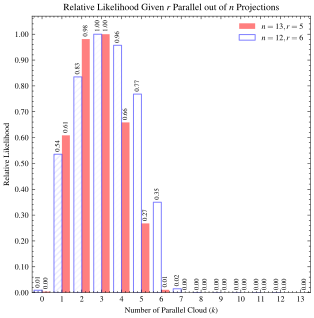

In [127]:
plot_fig_3(x1, likeli13_tot, x2, likeli12_tot, None)

In [102]:
prob13 = likeli13_tot/np.sum(likeli13_tot)
prob12 = likeli12_tot/np.sum(likeli12_tot)

In [105]:
prob13[1:6], prob12[1:7]

(array([0.17236298, 0.27781688, 0.28313055, 0.18648937, 0.07584655]),
 array([0.11977661, 0.18675667, 0.22370756, 0.21410515, 0.17187457,
        0.07826425]))

In [104]:
np.sum(prob13[1:6]), np.sum(prob12[1:7])

(0.9956463340139514, 0.9944847940839847)